Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.2980 - loss: 1.6850 - val_accuracy: 0.5881 - val_loss: 1.1904
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.6435 - loss: 1.1056 - val_accuracy: 0.7000 - val_loss: 0.9018
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.7080 - loss: 0.8475 - val_accuracy: 0.7429 - val_loss: 0.7627
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.7567 - loss: 0.7132 - val_accuracy: 0.7619 - val_loss: 0.6859
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7674 - loss: 0.6830 - val_accuracy: 0.8000 - val_loss: 0.6259
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7957 - loss: 0.6007 - val_accuracy: 0.7952 - val_loss: 0.5771
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accur

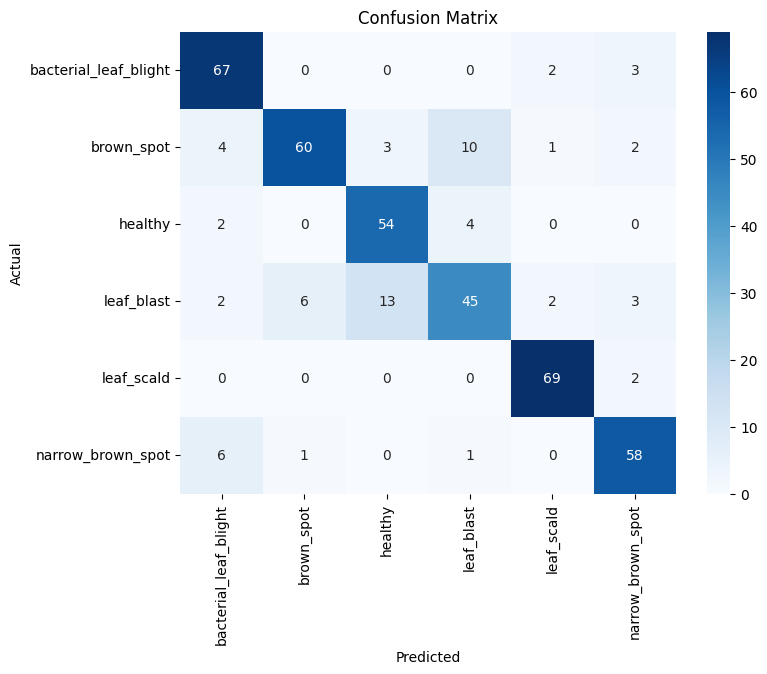

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
drive.mount('/content/drive')
# Define paths
dataset_path = r'/content/drive/MyDrive/RiceLeafsDisease/train'
image_size = (224, 224)  # EfficientNet input size

# Load dataset
def load_images_labels(dataset_path):
    X, y = [], []
    class_names = sorted(os.listdir(dataset_path))  # Ensure consistent label order
    class_mapping = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, image_size)
                    img = img / 255.0  # Normalize
                    X.append(img)
                    y.append(class_mapping[class_name])
                except:
                    print(f"Could not process {img_path}")

    return np.array(X), np.array(y), class_names

# Load data
X, y, class_names = load_images_labels(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# EfficientNet Model
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

# Custom Classifier on top of EfficientNet
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate Model
y_pred = np.argmax(model.predict(X_test), axis=1)

# Display Metrics
print('Accuracy:', np.mean(y_test == y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# *Early Detection Function*
def predict_early_symptom(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, image_size)
    img_normalized = img_resized / 255.0  # Normalize
    img_input = np.expand_dims(img_normalized, axis=0)

    probabilities = model.predict(img_input)[0] * 100
    prediction_idx = np.argmax(probabilities)
    predicted_class = class_names[prediction_idx]

    print("\n=== Rice Leaf Disease Prediction ===")
    print(f"Predicted Disease: {predicted_class}")
    print("Confidence Scores (%):")

    for label, prob in zip(class_names, probabilities):
        print(f"  - {label}: {prob:.2f}%")

    # *Early detection warning*
    if max(probabilities) < 60:
        print("\n⚠ *Early Detection Alert:* Symptoms may be in early stages. Consider monitoring this leaf.")

    print("\n===================================")

    # *Plot Probability Scores*
    plt.figure(figsize=(8, 5))
    sns.barplot(x=probabilities, y=class_names, palette="Blues_r")
    plt.xlabel("Confidence (%)")
    plt.ylabel("Disease Category")
    plt.title(f"Prediction Confidence for {predicted_class}")
    plt.xlim(0, 100)
    plt.show()

    # *Show input image with prediction*
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class} (Confidence: {probabilities[prediction_idx]:.2f}%)")
    plt.axis("off")
    plt.show()

# Example usage:
# predict_early_symptom('path_to_your_test_image.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

=== Rice Leaf Disease Prediction ===
Predicted Disease: healthy
Confidence Scores (%):
  - bacterial_leaf_blight: 0.20%
  - brown_spot: 5.56%
  - healthy: 64.88%
  - leaf_blast: 29.00%
  - leaf_scald: 0.07%
  - narrow_brown_spot: 0.30%



<ipython-input-8-02403e48c897>:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probabilities, y=class_names, palette="Blues_r")


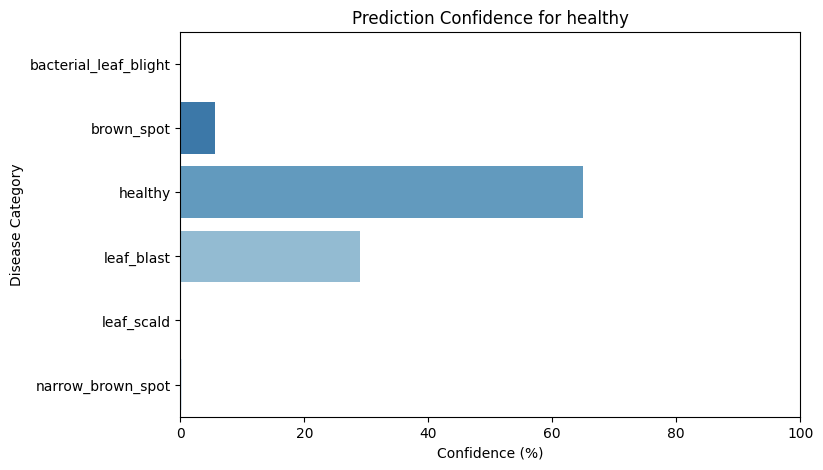

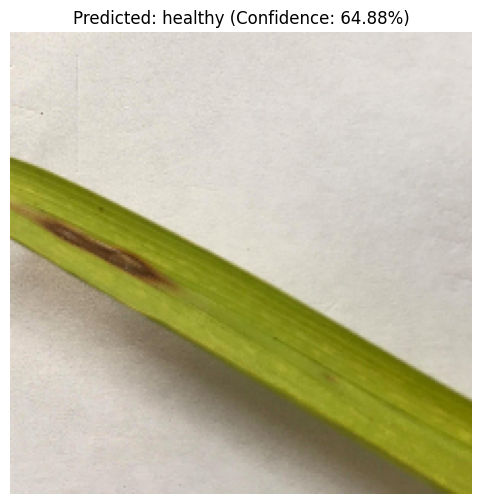

In [ ]:
image_path = r'/content/drive/MyDrive/RiceLeafsDisease/train/leaf_blast/leaf_blast (3).jpg'
predict_early_symptom(image_path)

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import pandas as pd

In [ ]:
# Load MobileNetV2 without top layer (for feature extraction)
feature_extractor = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Global Average Pooling to reduce feature dimensions
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.GlobalAveragePooling2D()
])

# Freeze the feature extractor weights
model.trainable = False

print("Feature extraction model loaded successfully!")

<ipython-input-9-c0fd95c2a624>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature extraction model loaded successfully!


Accuracy: 0.7690476190476191
Classification Report:
                        precision    recall  f1-score   support

bacterial_leaf_blight       0.97      0.94      0.95        66
           brown_spot       0.74      0.52      0.61        71
              healthy       0.72      0.78      0.75        72
           leaf_blast       0.65      0.62      0.63        71
           leaf_scald       0.90      0.82      0.86        80
    narrow_brown_spot       0.67      0.97      0.79        60

             accuracy                           0.77       420
            macro avg       0.77      0.77      0.77       420
         weighted avg       0.78      0.77      0.77       420



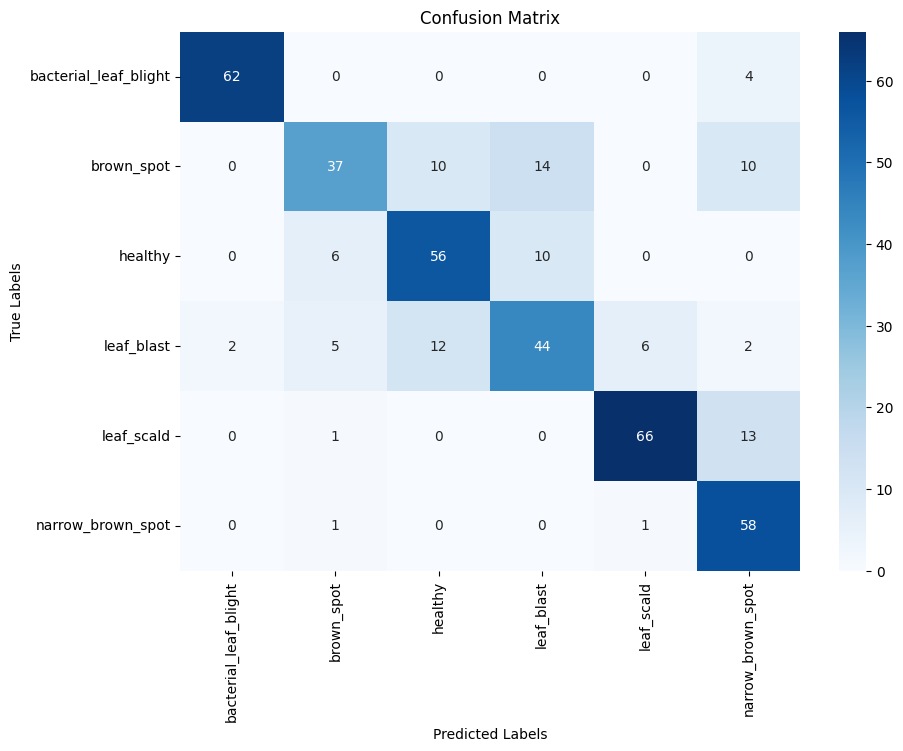

In [ ]:
import os
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Define the path to your dataset
train_path = r'/content/drive/MyDrive/RiceLeafsDisease/train'

# Define supported image formats
image_formats = {'.jpg', '.jpeg', '.png'}

# Function to extract features using Fixed Boundary Empirical Wavelet Transform (FBEWT)
def extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize image to a standard size

    # Decompose image using 2D Discrete Wavelet Transform
    coeffs = pywt.wavedec2(image, 'db1', level=2, mode='periodization')

    # Flatten the coefficients (approximation + details)
    features = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):  # For detail coefficients
            for subband in coeff:
                features.extend(subband.flatten())
        else:  # For approximation coefficients
            features.extend(coeff.flatten())

    return np.array(features)

# Load dataset
X, y = [], []

for folder_name in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if os.path.splitext(file_name)[1].lower() in image_formats:
                file_path = os.path.join(folder_path, file_name)
                features = extract_features(file_path)
                X.append(features)
                y.append(folder_name)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

# Display Accuracy and Classification Report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Prediction with probability function
def predict_disease(image_path):
    features = extract_features(image_path).reshape(1, -1)
    prediction = clf.predict(features)[0]
    probabilities = clf.predict_proba(features)[0] * 100
    probability_dict = {label: prob for label, prob in zip(clf.classes_, probabilities)}

    print(f'Predicted Disease: {prediction}')
    print('Prediction Probabilities (%):')
    for label, prob in probability_dict.items():
        print(f'{label}: {prob:.2f}%')




In [ ]:
!pip install efficientnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install PyWavelets --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.5 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:26:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.77      0.82      0.79        72
           1       0.91      0.89      0.90        80
           2       0.79      0.92      0.85        60
           3       0.80      0.69      0.74        71
           4       0.83      0.75      0.79        71
           5       0.91      0.97      0.94        66

    accuracy                           0.84       420
   macro avg       0.83      0.84      0.83       420
weighted avg       0.84      0.84      0.83       420



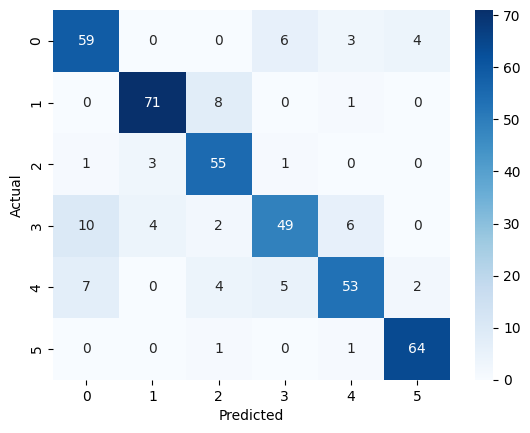

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from google.colab import drive

drive.mount('/content/drive')

# Define dataset path
dataset_path = r'/content/drive/MyDrive/RiceLeafsDisease/train'

# Load images and labels
image_size = (224, 224)
X = []
y = []
labels = os.listdir(dataset_path)
label_map = {label: idx for idx, label in enumerate(labels)}

for label in labels:
    class_path = os.path.join(dataset_path, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize
        X.append(img)
        y.append(label_map[label])

X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Extraction using EfficientNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Define classifiers
svm = SVC(probability=True)
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Voting Classifier
voting_clf = VotingClassifier(estimators=[('svm', svm), ('rf', rf), ('xgb', xgb)], voting='soft')

# Train classifier
voting_clf.fit(X_train_features, y_train)

# Predictions
y_pred = voting_clf.predict(X_test_features)

# Evaluate performance
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
drive.mount('/content/drive')
# Define paths
dataset_path = r'/content/drive/MyDrive/RiceLeafsDisease/train'

Mounted at /content/drive
